In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import rcParams, pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

rcParams['figure.figsize'] = [12, 8]
rcParams['figure.dpi'] = 200

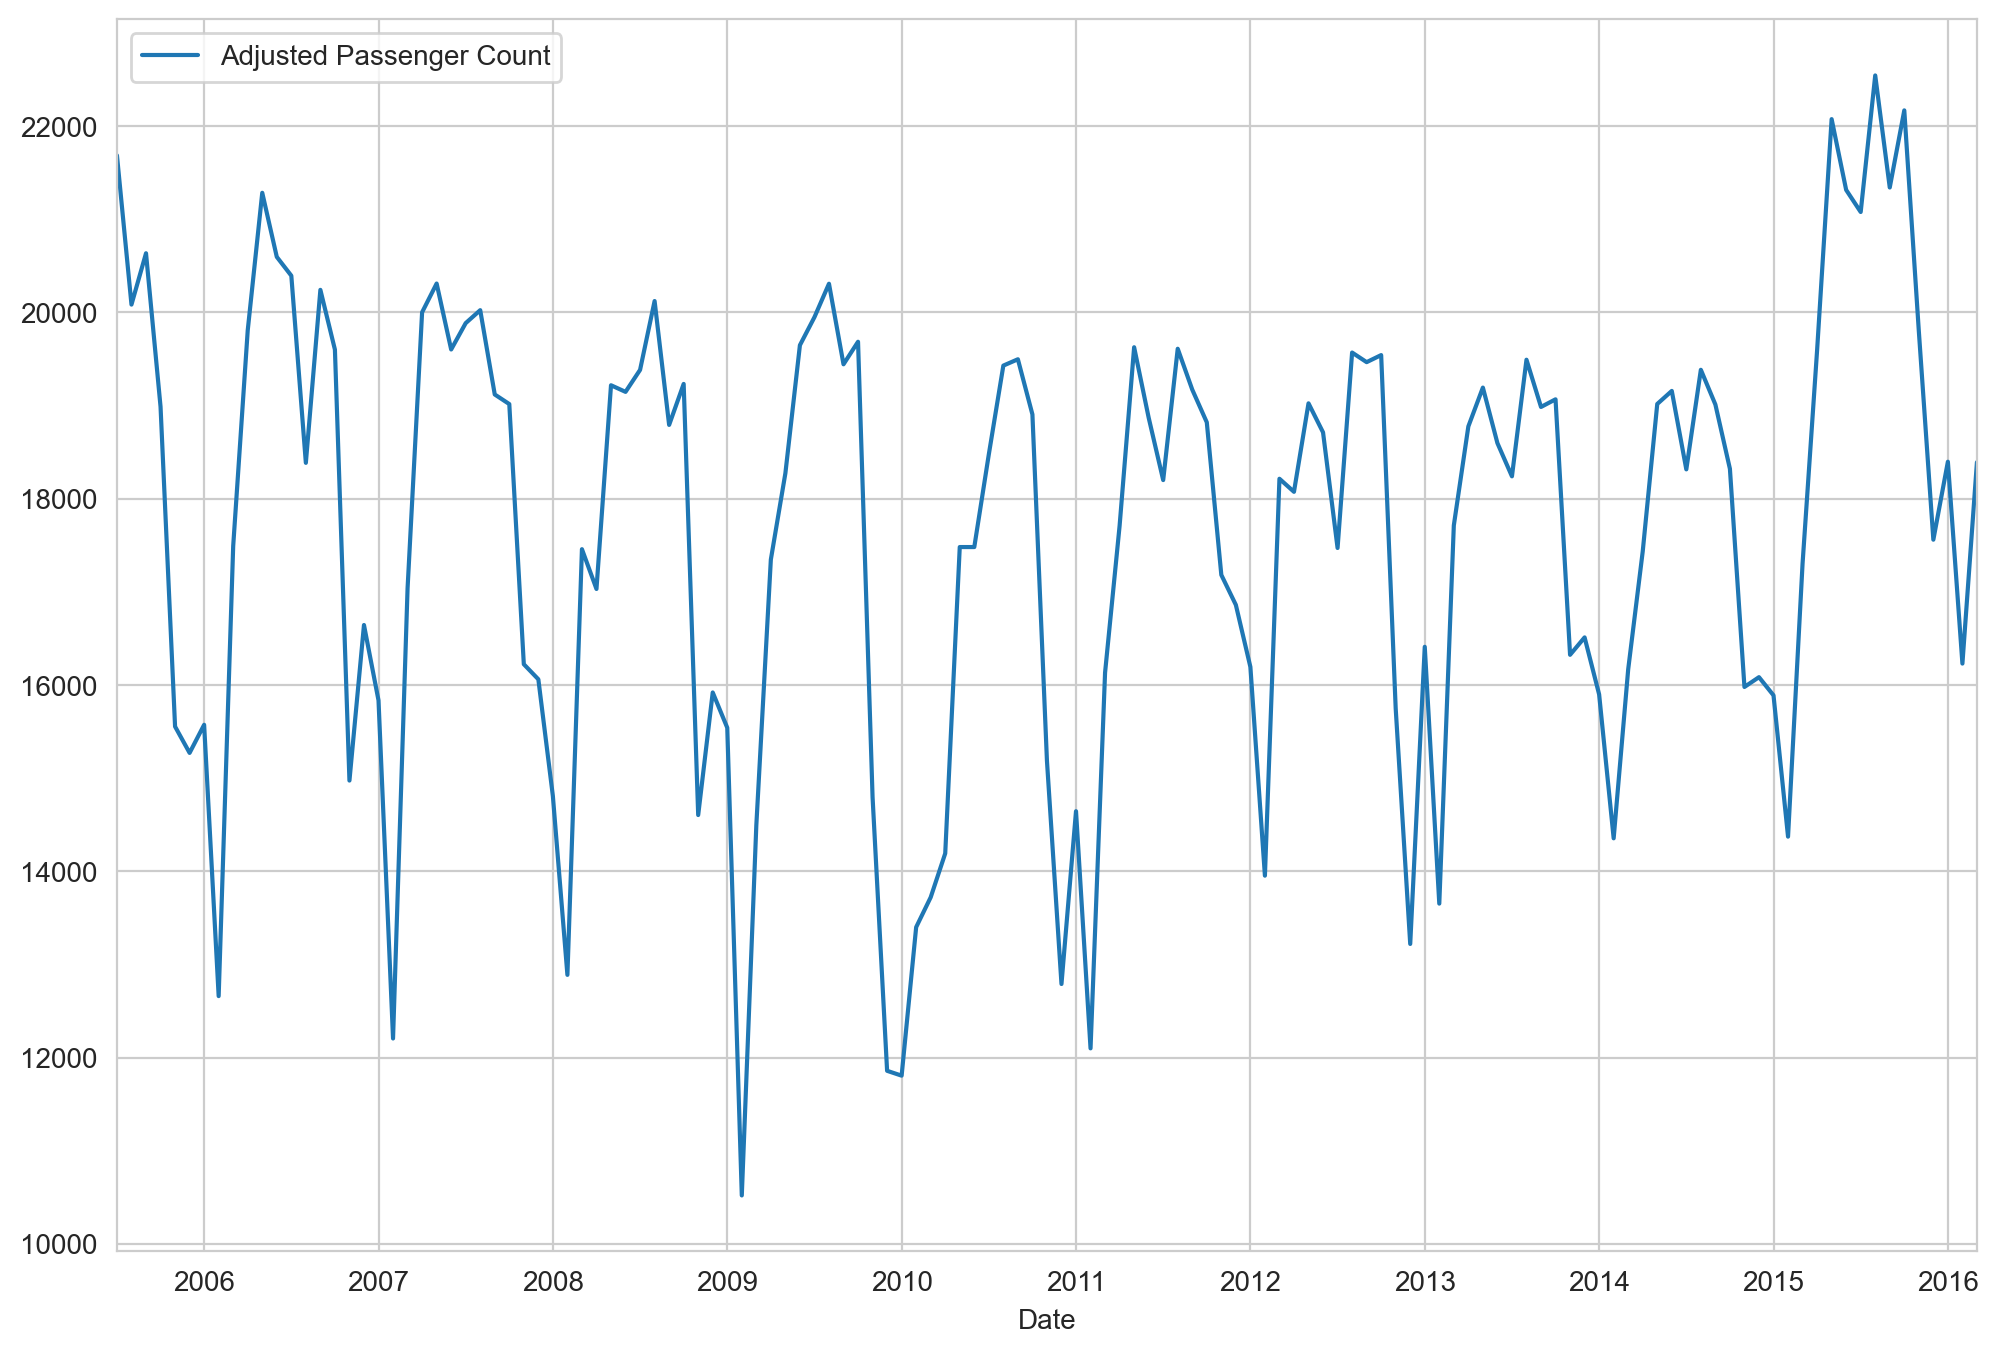

In [17]:
data = pd.read_csv('data/british airways.csv',
                 index_col='Date',
                 parse_dates=['Date'],
                 dtype={'Adjusted Passenger Count': float})
data.index.freq = 'MS'
_ = data.plot()

In [18]:
data_tensor = tf.convert_to_tensor(data['Adjusted Passenger Count'].to_numpy(), dtype=tf.float64)
data_index = data.index

train_data, test_data = train_test_split(data, test_size=0.1, shuffle=False)
train_data_tensor = tf.convert_to_tensor(train_data['Adjusted Passenger Count'].to_numpy(), dtype=tf.float64)
test_data_tensor = tf.convert_to_tensor(test_data['Adjusted Passenger Count'].to_numpy(), dtype=tf.float64)
train_data_index, test_data_index = data_index[:len(train_data_tensor)], data_index[len(train_data_tensor):]

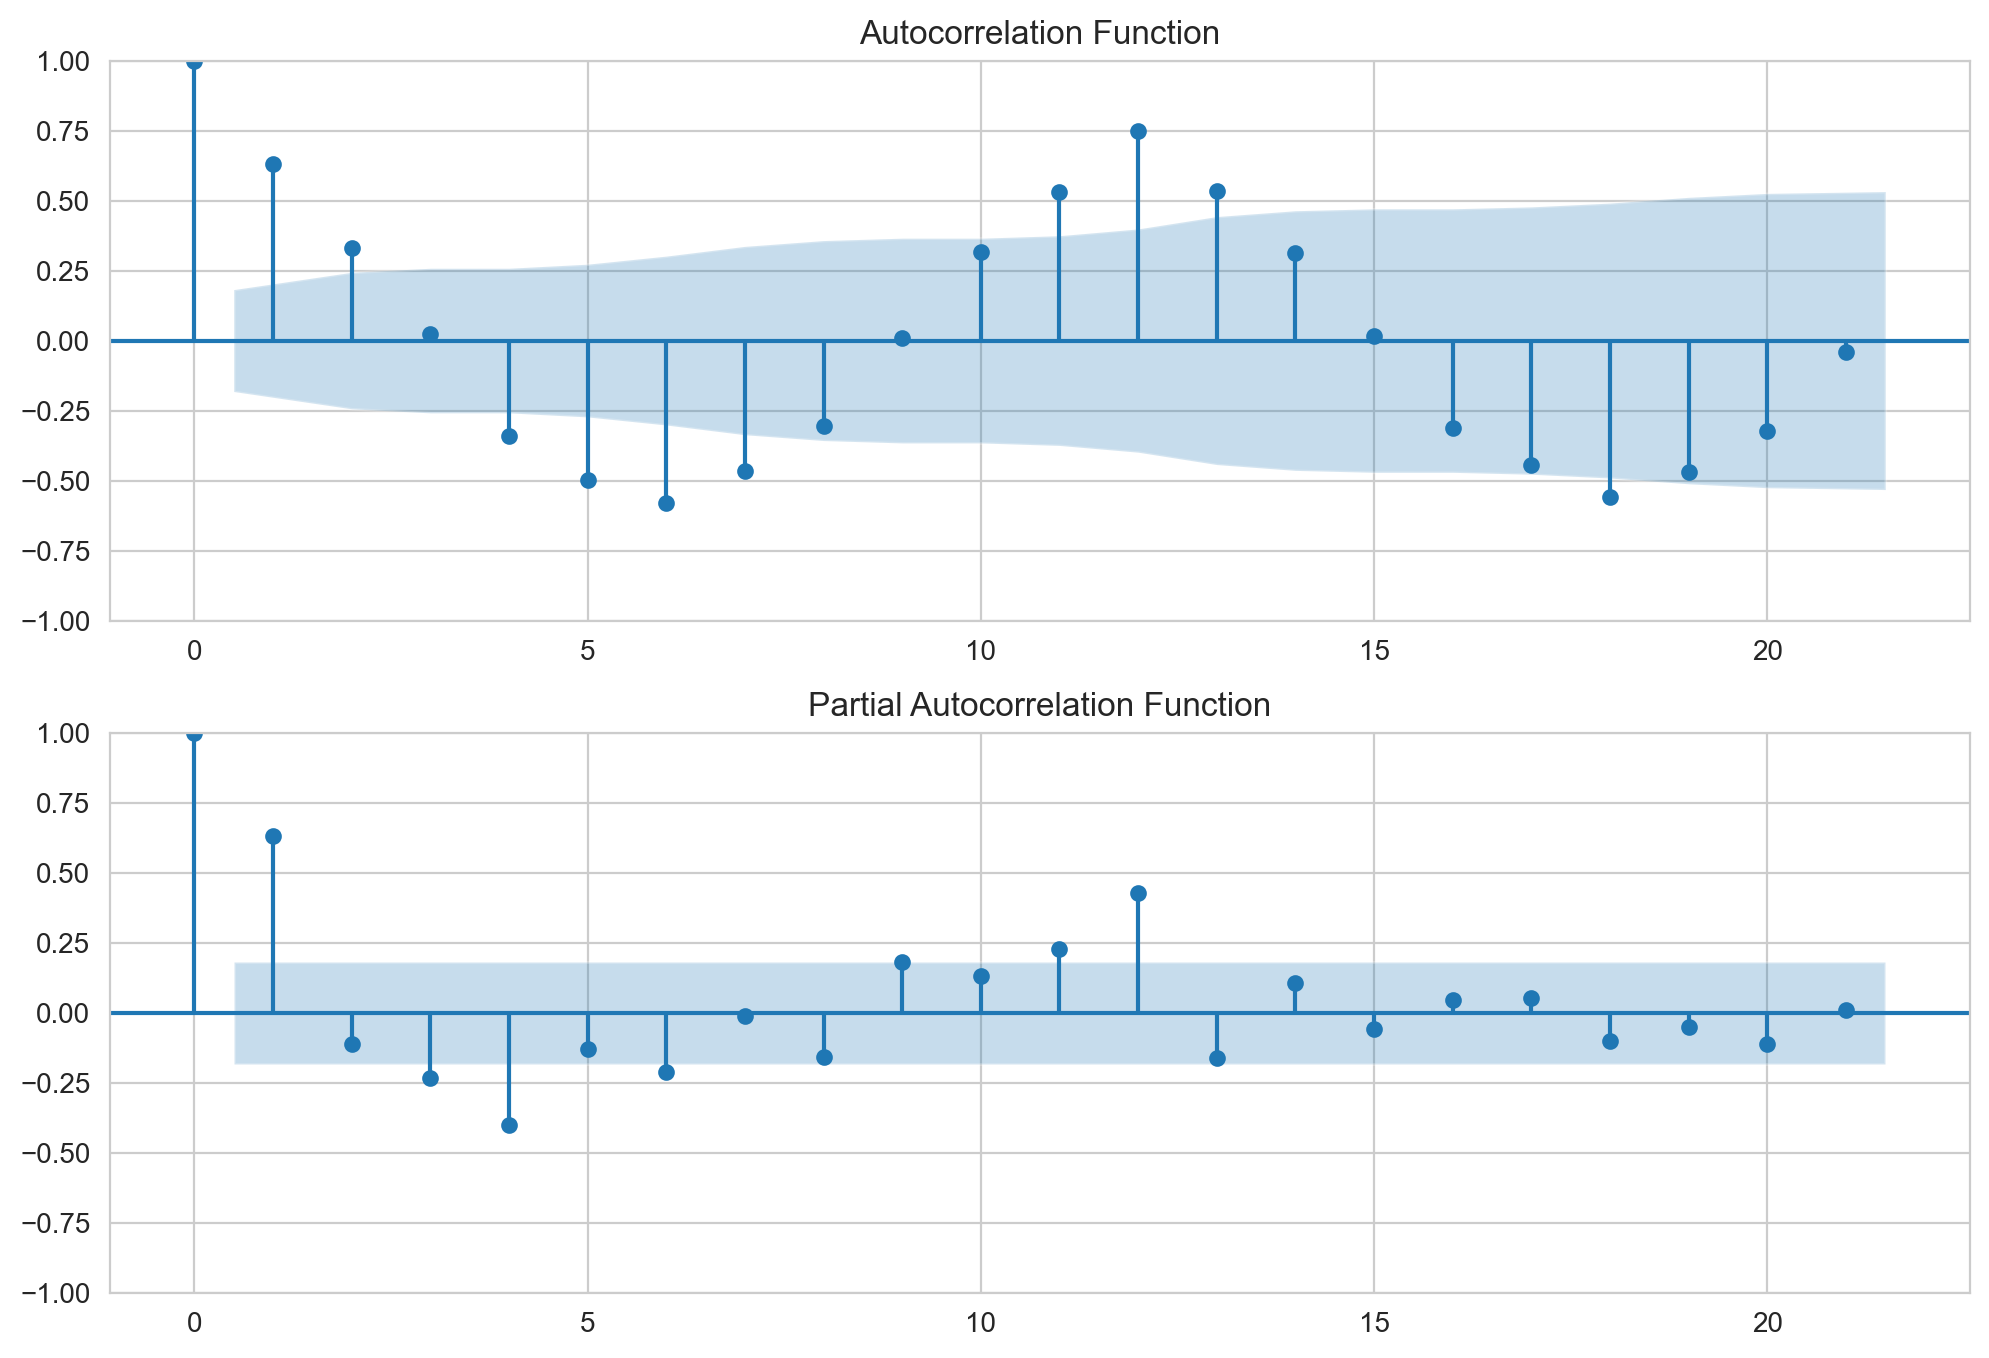

In [19]:
_, axs = plt.subplots(nrows=2, ncols=1, figsize=(12,8))

plot_acf(train_data_tensor, ax=axs[0])
axs[0].set_title('Autocorrelation Function')

plot_pacf(train_data_tensor, ax=axs[1], method='ywm')
axs[1].set_title('Partial Autocorrelation Function')

plt.show()

In [20]:
def build_model(observed_time_series, num_seasons: int):
    trend = tfp.sts.LocalLinearTrend(observed_time_series=observed_time_series)
    seasonal = tfp.sts.Seasonal(num_seasons=num_seasons, observed_time_series=observed_time_series)
    residual_level = tfp.sts.Autoregressive(order=1, observed_time_series=observed_time_series, name='residual')
    autoregressive = tfp.sts.Autoregressive(order=1, observed_time_series=observed_time_series, name='autoregressive')
    return tfp.sts.Sum([trend, seasonal, residual_level, autoregressive], observed_time_series=observed_time_series)

In [21]:
with tf.device('CPU:0'):
    model = build_model(train_data_tensor, 12)
    variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=model)

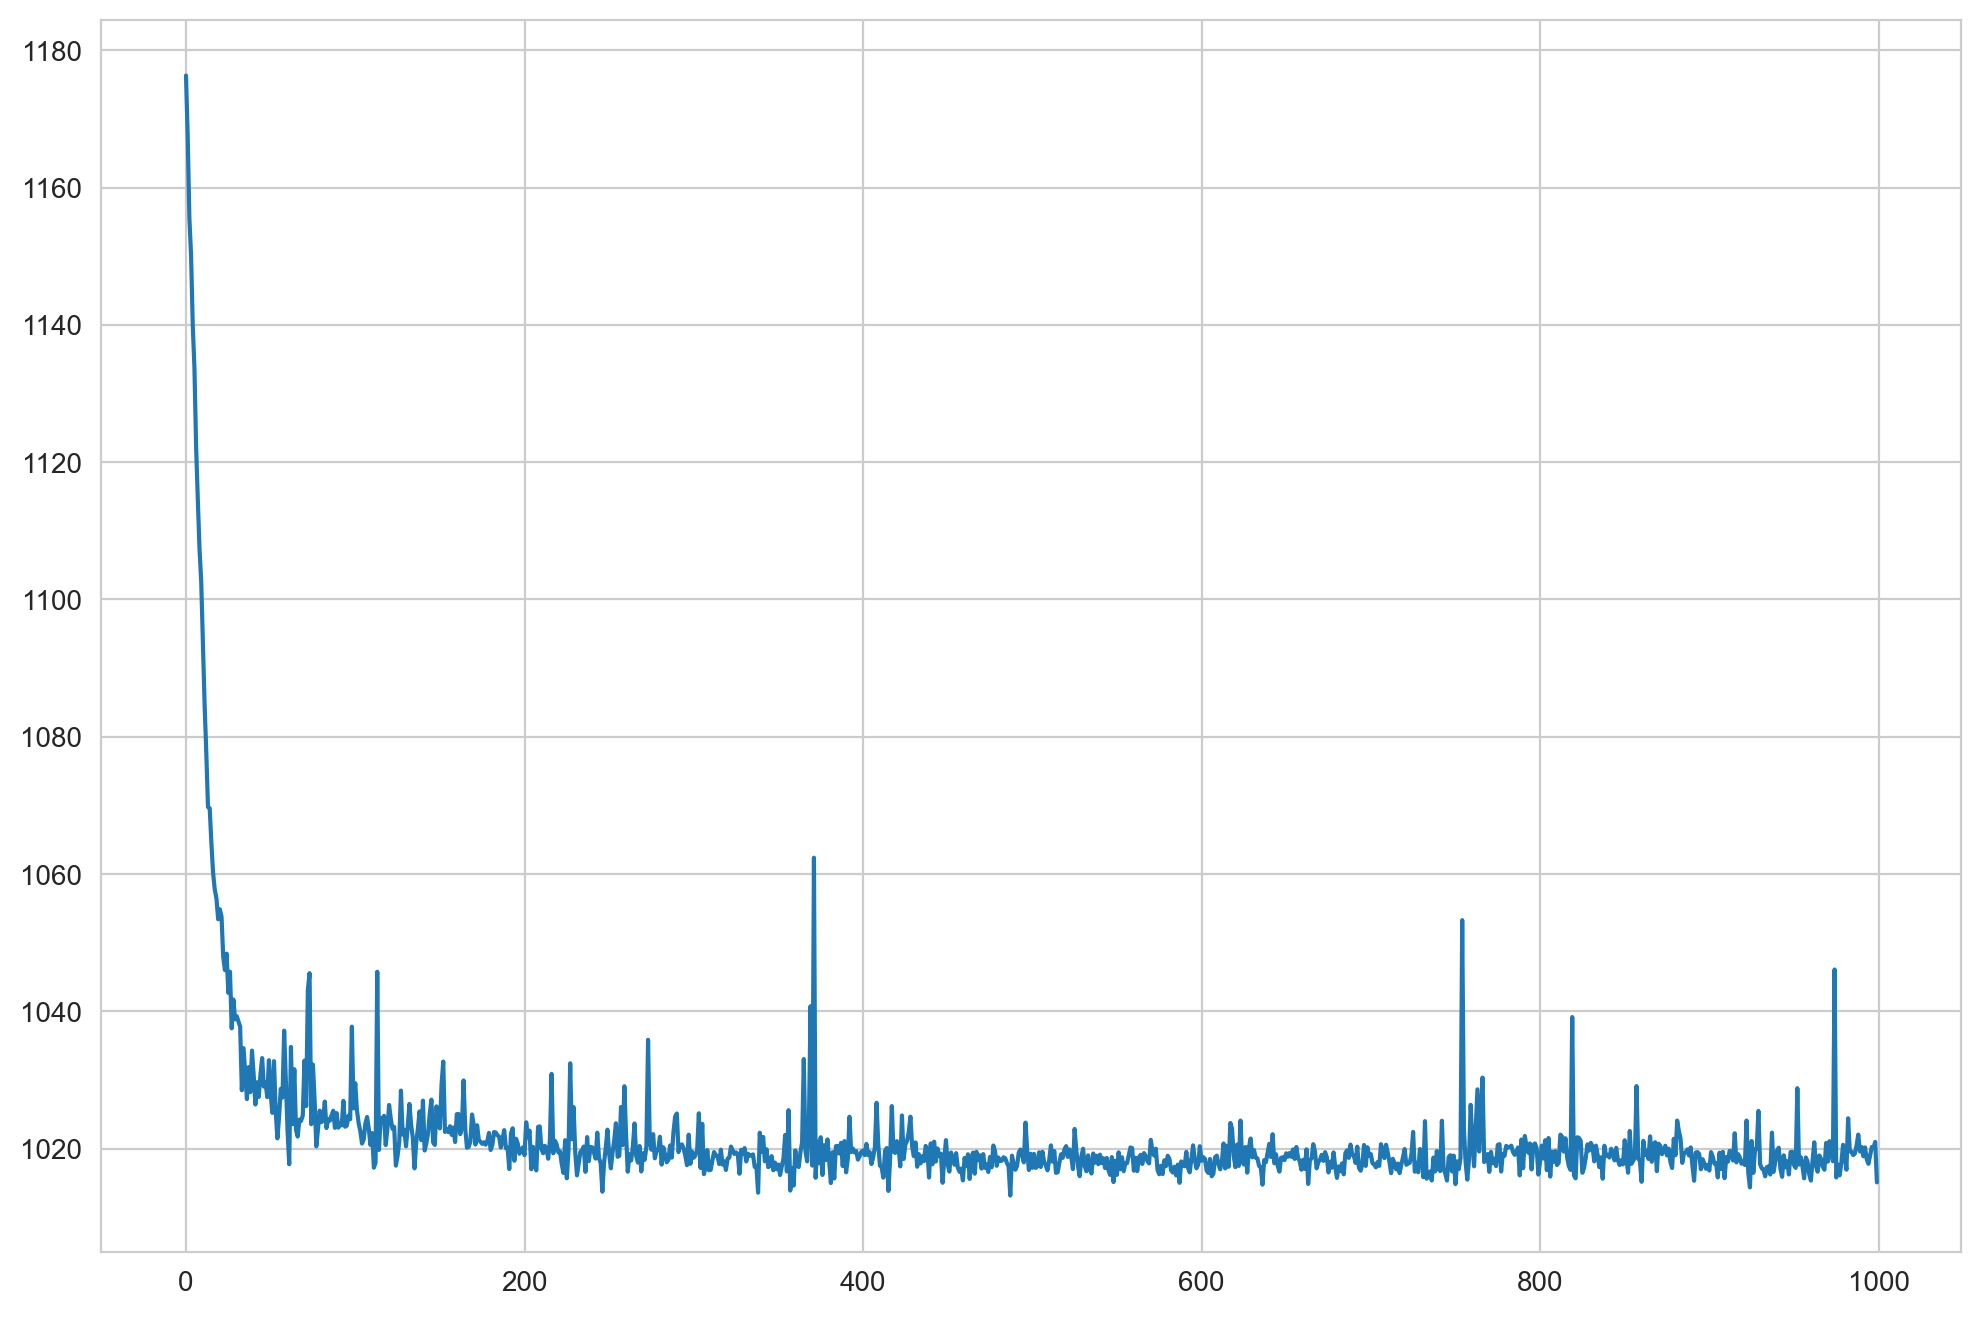

In [22]:
num_variational_steps = 1000
num_variational_steps = int(num_variational_steps)

optimizer = tf.optimizers.legacy.Adam(learning_rate=.1)
@tf.function(experimental_compile=True)
def train():
    return tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=model.joint_log_prob(observed_time_series=train_data_tensor),
        surrogate_posterior=variational_posteriors,
        optimizer=optimizer,
        num_steps=num_variational_steps)

with tf.device('CPU:0'):
    elbo_loss_curve = train()

plt.plot(elbo_loss_curve)
plt.show()

parameter_samples = variational_posteriors.sample(1000)

In [23]:
print("Inferred parameters:")
for param in model.parameters:
    print("{}: {} +- {}".format(param.name,
                                np.mean(parameter_samples[param.name], axis=0),
                                np.std(parameter_samples[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 48.38876479140103 +- 128.69100736815673
LocalLinearTrend/_level_scale: 68.03690113900204 +- 157.9484538892578
LocalLinearTrend/_slope_scale: 11.463984531718351 +- 9.92213484224579
Seasonal/_drift_scale: 11.134634423614273 +- 18.307229771260506
residual/_coefficients: [0.06098583] +- [0.31729784]
residual/_level_scale: 12.61018622636642 +- 11.060779372466138
autoregressive/_coefficients: [0.34429578] +- [0.16444456]
autoregressive/_level_scale: 968.4442447771147 +- 53.406735413278476


In [24]:
forecast_dist = tfp.sts.forecast(model,
                                 observed_time_series=train_data_tensor,
                                 parameter_samples=parameter_samples,
                                 num_steps_forecast=len(test_data_tensor))

In [31]:
num_samples=5000

forecast_mean, forecast_scale, forecast_samples = (
    forecast_dist.mean().numpy()[..., 0],
    forecast_dist.stddev().numpy()[..., 0],
    forecast_dist.sample(num_samples).numpy()[..., 0],
)

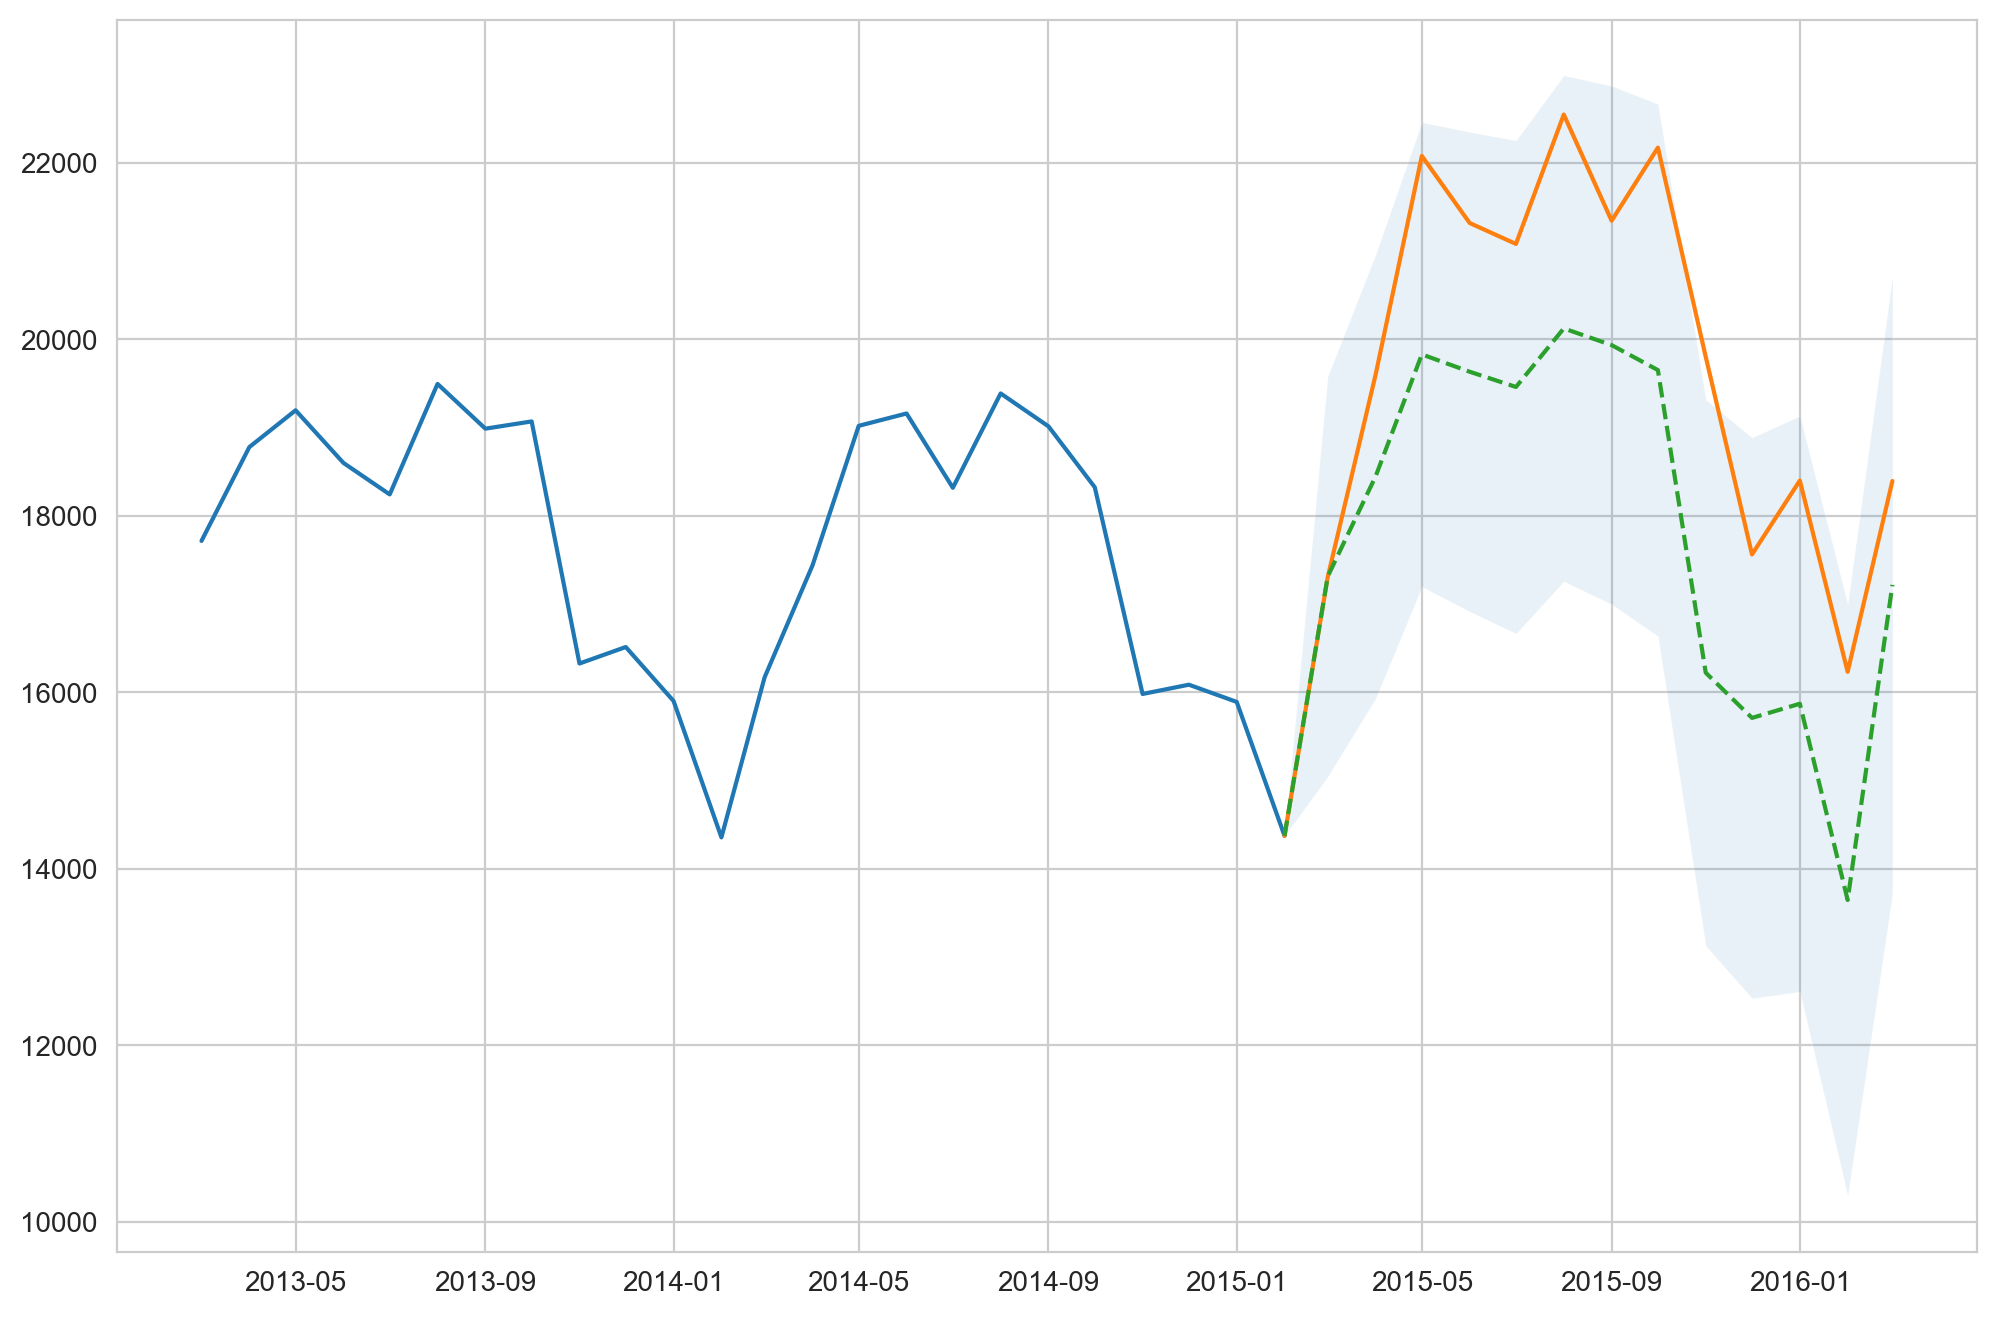

In [26]:
last_date, last_observation = train_data_index[-1], train_data_tensor[-1]
test_data_index_ext = pd.DatetimeIndex([last_date]).union(test_data_index)
test_data_tensor_ext = tf.concat([[last_observation], test_data_tensor], axis=0)
forecast_mean_ext = np.concatenate(([last_observation], forecast_mean))
forecast_scale_ext = np.concatenate(([0], forecast_scale))

plt.plot(train_data_index[-24:], train_data_tensor[-24:], label='Training Data')
plt.plot(test_data_index_ext, test_data_tensor_ext, label='Test Data')

plt.plot(test_data_index_ext, forecast_mean_ext, label='Forecast', linestyle='--')

_ = plt.fill_between(test_data_index_ext,
                     forecast_mean_ext - 2 * forecast_scale_ext,
                     forecast_mean_ext + 2 * forecast_scale_ext,
                     alpha=0.1)

In [27]:
component_dists = tfp.sts.decompose_by_component(model,
                                                 observed_time_series=train_data_tensor,
                                                 parameter_samples=parameter_samples)
component_means_, component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()}
)

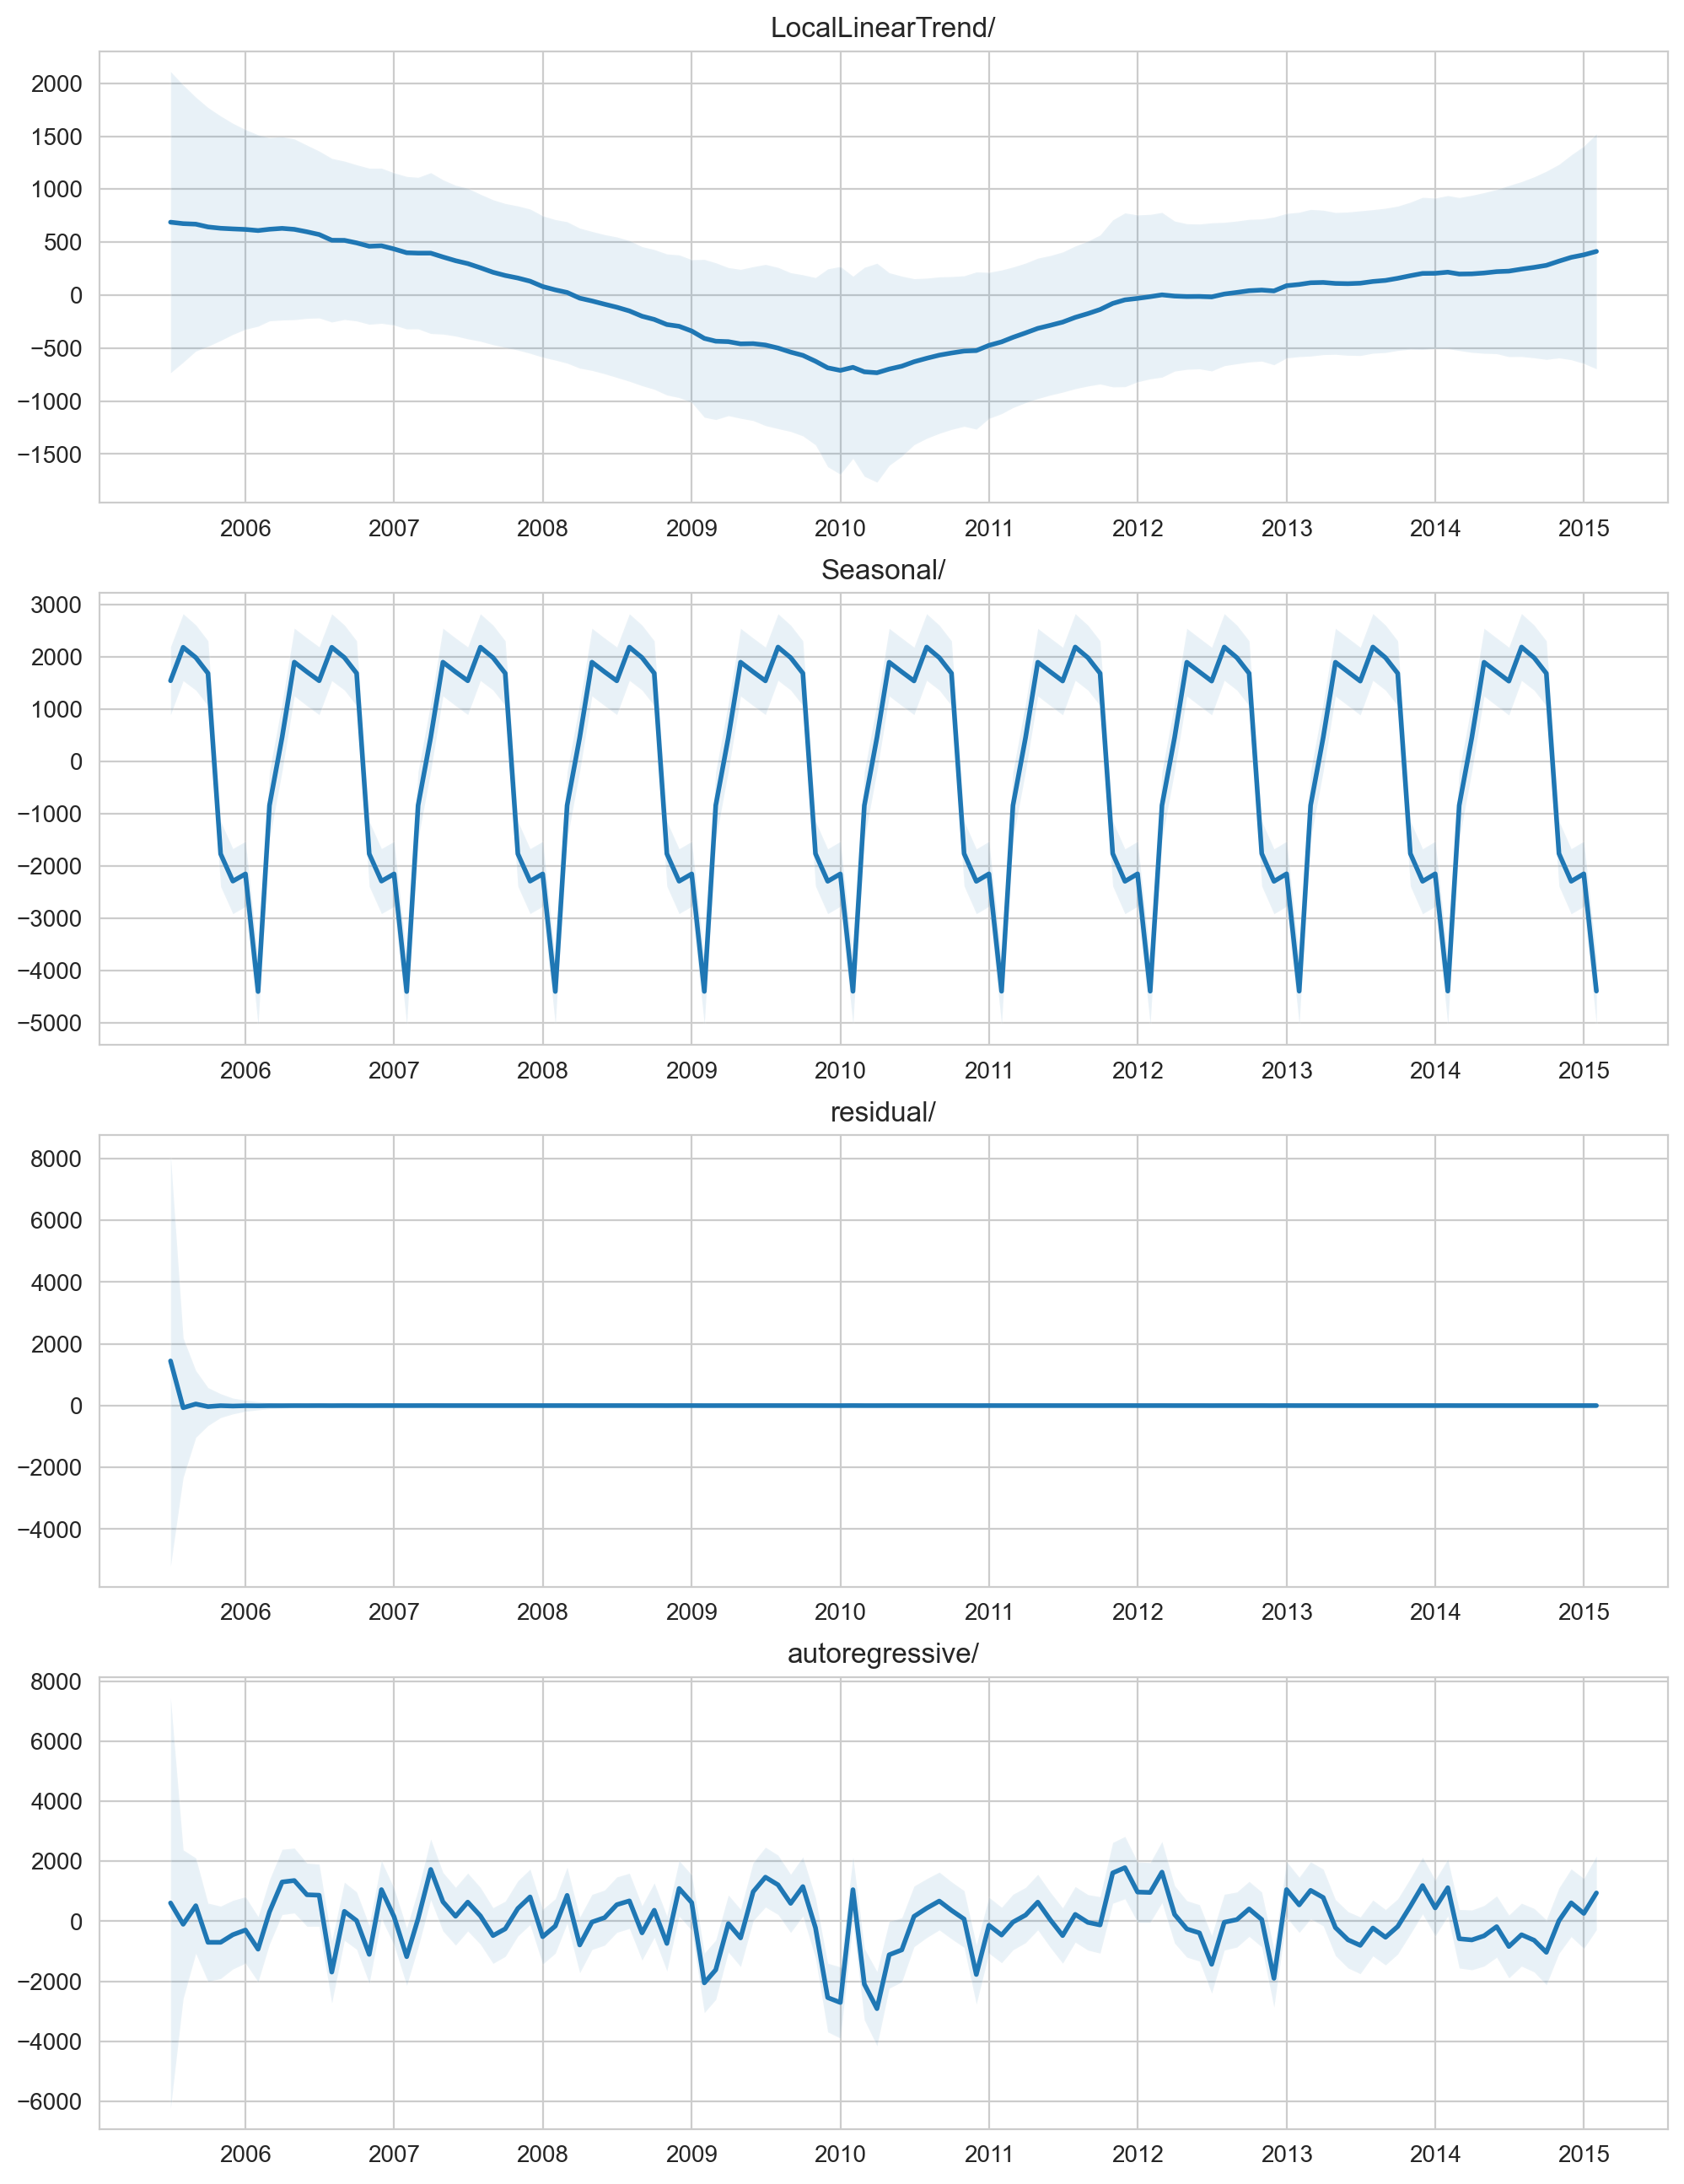

In [28]:
num_components = len(component_means_)

_, axs = plt.subplots(nrows=num_components, ncols=1, figsize=(12,16))
for i, component_name in enumerate(component_means_.keys()):
    component_mean   = component_means_[component_name]
    component_stddev = component_stddevs_[component_name]

    axs[i].plot(train_data.index, component_mean, lw=2)
    axs[i].fill_between(train_data.index,
                        component_mean - 2 * component_stddev,
                        component_mean + 2 * component_stddev,
                        alpha=0.1)
    axs[i].set_title(component_name)

In [29]:
tseries_one_step_dist = tfp.sts.one_step_predictive(model,
                                                    observed_time_series=train_data_tensor,
                                                    parameter_samples=parameter_samples)

tseries_one_step_mean, tseries_one_step_scale = (tseries_one_step_dist.mean().numpy(), tseries_one_step_dist.stddev().numpy())

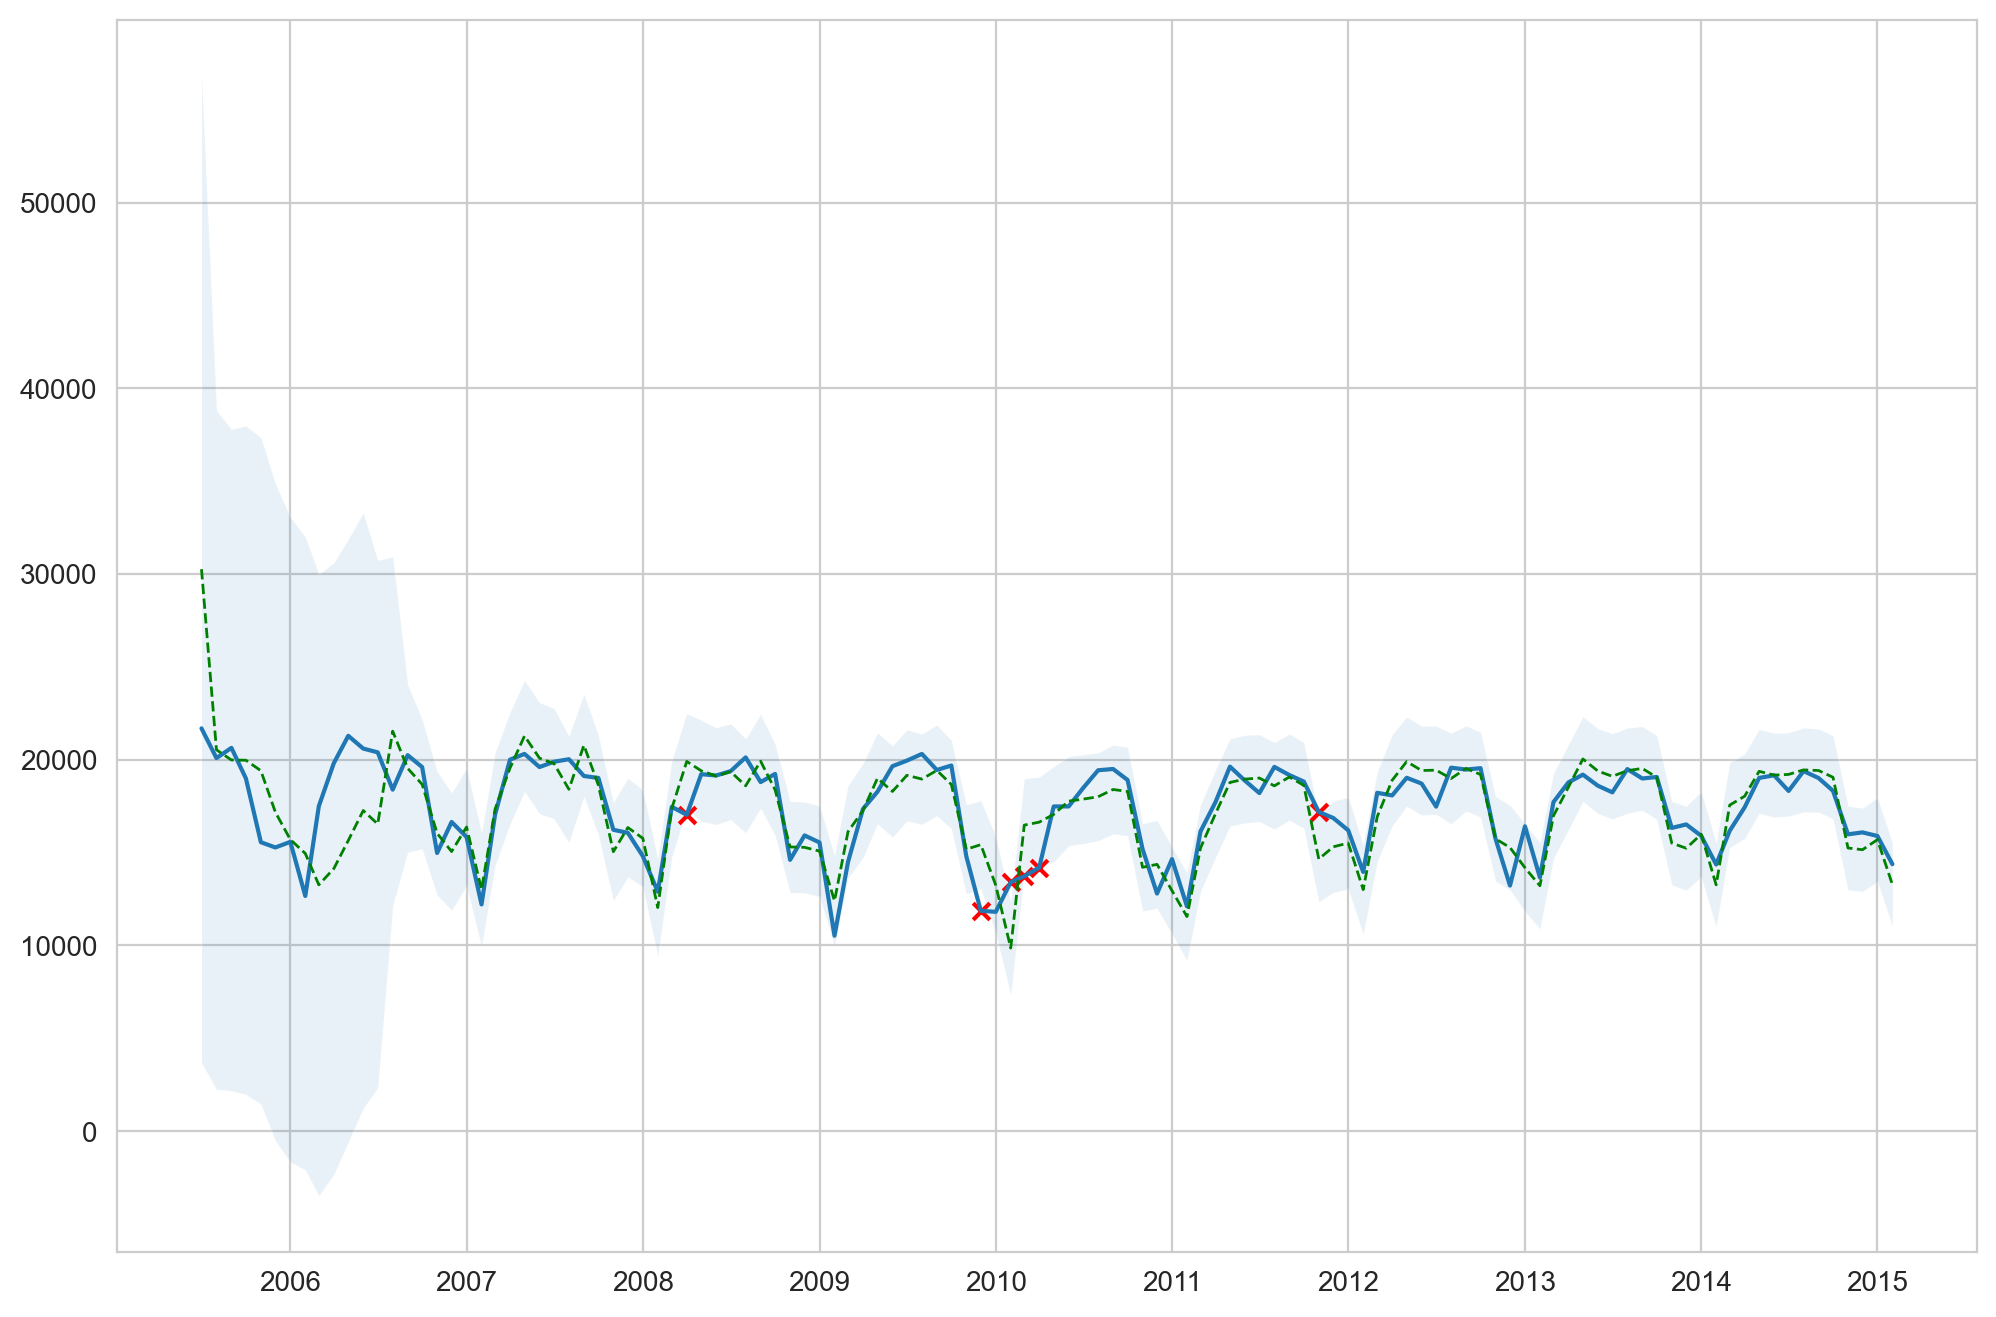

In [33]:
z_score = 2

plt.plot(train_data.index, train_data_tensor, label='Observed Time Series')

lower_bound = tseries_one_step_mean - z_score * tseries_one_step_scale
upper_bound = tseries_one_step_mean + z_score * tseries_one_step_scale

plt.fill_between(train_data.index, lower_bound, upper_bound, alpha=0.1, label='One Step Prediction Interval')

plt.plot(train_data.index, tseries_one_step_mean, color='green', linestyle='--', linewidth=1, label='One Step Prediction')

outliers = (train_data_tensor < lower_bound) | (train_data_tensor > upper_bound)
outlier_indices = np.where(outliers)[0]
_ = plt.scatter(train_data.index[outlier_indices], train_data_tensor[outliers], marker='x', color='red', label='Outliers')